In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Portfolio Optimization

$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$

-----
## Overview

This notebook is the third in the "[Quantum Applications to Finance](https://github.com/NVIDIA/cuda-q-academic/tree/main/quantum-applications-to-finance)" series. In this notebook you will perform a fundamental financial task - portfolio optimization.  You will learn how to setup the optimization problem, solve it using two different quantum methods, add constraints, and explore methods for scaling up such approaches. This notebook will also explore the state-of-the-art Q-CHOP algorithm developed by Infleqtion (also contributors to this notebook) and JPMorgan Chase demonstrating how the fundamental examples you code up with CUDA-Q can be extended towards useful real-world applications.

**What you'll do:**
* Setup a QUBO portfolio optimization problem
* Map the problem to a quantum Hamiltonian
* Solve the problem with a QAOA implementation in CUDA-Q
* Solve the problem with an adiabatic implementation with CUDA-Q dynamics
* Add constraints to the optimization problem
* Learn how Q-CHOP can improve quantum portfolio optimization
* Explore how multiple QPUs can help scale up portfolio sampling


**CUDA-Q Syntax you'll use:**
* quantum kernel function decoration: `@cudaq.kernel`
* qubit initialization: `cudaq.qvector` and `cudaq.qubit`
* quantum gates: `x`, `h`, `t`, `_.ctrl`, `cudaq.register_operation`
* CUDA-Q spin operators: `spin`
* execute a kernel: `sample`, `get_state`, `observe`
* Analyze sample results `.count`
* Run `dynamics` backend with `evolve`
* Run `mqpu` backend with `sample_async`

Pre-requisites: Learners should have familiarity with Jupyter notebooks and programming in Python and CUDA-Q. It is assumed the reader has some familiarity already with quantum computation and is comfortable with braket notation and the concepts of qubits, quantum circuits, measurement, Hamiltonians, and circuit sampling. The CUDA-Q Academic course entitled "[Quick Start to Quantum Computing with CUDA-Q](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum)" provides a walkthrough of this prerequisite knowledge if the reader is new to quantum computing and CUDA-Q or needs refreshing.  While not required, the notebook titled "[Lab 1 - Overview: Max cut with QAOA on a small graph](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/01_Max-Cut-with-QAOA.ipynb)" provides additional context for the Quantum Approximate Optimization Algorithm (QAOA) covered here.


First run the cells below to load the necessary packages for this notebook.

In [ ]:
## Instructions for Google Colab. You can ignore this cell if you have cuda-q set up and have 
# all the dependent files on your system
# Uncomment the lines below and execute the cell to install cuda-q

#!pip install cudaq

#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
#!unzip -q main.zip
#!mv cuda-q-academic-main/quantum-applications-to-finance/images ./images

In [1]:
%pip install ipywidgets -q
import numpy as np
import itertools, math
import cudaq
from cudaq import spin 
from typing import List, Tuple
from itertools import combinations
from scipy.optimize import minimize
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


------

## Introduction

Portfolio optimization is foundational for modern finance. The aim of portfolio optimization is to select the best combination of assets to maximize returns while minimizing risk. Qualitatively, this looks like the portfolio in the leftmost point of the "universe" of potential portfolios pictured below. 

<img src="images/portfolioopt.png" alt="Graph of Portfolio Optimization" style="width: 900px;"/>


Seminal to this field is Harry Markowitz's Modern Portfolio Theory (MPT), introduced in the 1950s. Markowitz's groundbreaking work established the framework for diversification, demonstrating that the risk of a portfolio is not merely the sum of the risks of its individual assets. Instead, by carefully selecting a mix of assets with varying correlations, investors can reduce the overall portfolio risk. 


Even with such insights, identifying good portfolios is extremely challenging when there are seemingly endless choices for investment selections.  Moreover, fund managers can add additional complexity by changing the weights of each portfolio or considering schemes where stock inclusion is not binary, but can include a number of different strategies.

Regardless of the setup, the biggest challenge for portfolio optimization is the combinatorial scaling of the universe of potential portfolios. It is well within the bounds of practicality to consider, for example, a portfolio constructed from 20 Fortune 100 stocks which is selected from 100 choose 20 or quintillions ($10^{20}$) of potential portfolios. This is where quantum computing might be able to help. 

The idea is to encode the problem into a quantum state consisting of $n=100$ qubits. A clever algorithm could leverage the properties of superposition, entanglement, and interference to evolve this state towards a final state from which quality portfolios can be sampled with a high probability.  This avoids the need for brute force search of all $10^{20}$ portfolios and potentially provides a much more efficient means to sample optimal portfolios.

The simplest formulation of a portfolio optimization is an equal weighted quadratic unconstrained binary optimization (QUBO). The QUBO formulation is presented in the following equation.

$$\min_{x} (-\alpha x^T\mu + \beta x^T\sigma x) = \min_{x} (x^TQx) = \min_{x} (\sum_i Q_{ii} x_i + \sum_{i<j} Q_{ij} x_i  x_j )$$

The $x$ vector is binary (1 or 0 entries) and is of length $n$ (total possible stocks) where the portfolio is indicated by the subset of 1 entries. The $\mu$ vector and $\sigma$ matrix contain information about the return of each stock and the covariance between pairs of stocks. This information is generally obtained from historical data which is an helpful but imperfect indicator of future behavior. Finally, the $\alpha$ and $\beta$ terms are  parameters that weigh the importance of risk and reward. 

**Exercise 1:**

Given the $\alpha$, $\beta$, $\mu$ and $\sigma$ values below, write code to produce the QUBO matrix $Q$.  Note, in practice, the matrix is usually made upper diagonal by doubling the upper diagonal entries and zeroing out the lower diagonal entries.  This saves space rather than having two terms correspond to the same correlation.


In [ ]:
mu = np.array([0.80, 0.70, 0.25, 0.20])          # expected returns
Sigma = np.array([[0.90, 0.45, 0.55, 0.10],      # variances / covariances
                  [0.45, 0.40, 0.30, 0.08],
                  [0.55, 0.30, 0.25, 0.05],
                  [0.10, 0.08, 0.05, 0.05]])
alpha, beta = 1.0, 1.0
n = len(mu)

def portfolio_to_qubo(mu, Sigma, alpha=1., beta=1.):
    """
    Convert financial data into a QUBO Matrix
    
    Args:
        mu (np.array): length n vector of portfolio returns
        Sigma (np.array): nxn matrix of portfolio pair covariances
        alpha (float): tunable parameter for valuing return
        beta (float): tunable parameter for valuing risk

    
    Returns:
        Q (np.array): upper triangular QUBO Matrix
    """
    
    #TODO Start
    n = len(mu)
    Q = np.zeros((n, n))
    for i in range(n):
        Q[i, i] = #FIX_ME#
    for i, j in combinations(range(n), 2):
        Q[i, j] = #FIX_ME#
    return Q

Q = portfolio_to_qubo(mu, Sigma, alpha, beta)
print(Q)
#TODO End

Now, write a code that generates all of the possible portfolios, evaluates the portfolio quality by manually computing $x^TQx$, and returns the best portfolio.

In [ ]:
def evaluate_all_bitstrings(Q):
    """
    Evaluate QUBO objective x^T Q x for all possible bitstrings.
    
    Args:
        Q (np.ndarray): QUBO matrix (nxn)
        verbose (bool): Print all solutions if True
    
    Returns:
        best_x (np.array): Optimal bitstring
        best_val (float): Optimal objective value
        all_solutions (list): List of (bitstring, value) tuples
    """

    #TODO Start
    n = Q.shape[0]
    
    # Generate all possible bitstrings
    bitstrings = list(itertools.product([0, 1], repeat=n))
    
    # Evaluate each bitstring 
    # Keep a running list of solutions and best and worst values
    solutions = []
    best_val = float('inf')
    best_x = None
    worst_val = float('-inf')
    worst_x = None
    
    # EDIT CODE BELOW THIS LINE
            
    # EDIT CODE BELOW THIS LINE
    
    # Sort solutions by objective value
    solutions.sort(key=lambda x: x[1])
    
    print("\nBest solution:")
    print(f"x* = {best_x}")
    print(f"Objective value = {best_val:.6f}")

    print("\nWorst solution:")
    print(f"x* = {worst_x}")
    print(f"Objective value = {worst_val:.6f}")

    #print("\nAll solutions:")
    #print(solutions)
    
    return best_x, best_val, worst_x, worst_val, solutions
    
best_x, best_val, worst_x, worst_val, all_solutions = evaluate_all_bitstrings(Q)
#TODO End


Best solution:
x* = [0 1 0 0]
Objective value = -0.300000

Worst solution:
x* = [1 1 1 1]
Objective value = 2.710000


Now explore the widget below that allows you to change $\alpha$ and $\beta$. Try the following scenarios. 

- $\alpha=3$ and $\beta =1$
- $\alpha=1$ and $\beta =2$

Can you rationalize the optimal portfolios produced by these settings?  Hint: study $\mu$ and $\sigma$.

<iframe src="https://nvidia.github.io/cuda-q-academic/quantum-applications-to-finance/images/QUBO_widget.html" width="800" height="600"></iframe>



## From QUBO to Spin Operator Hamiltonian

The QUBO is a useful format because it is well understood how to map a QUBO to a quantum Hamiltonian whose ground state corresponds to the QUBO solution.  In the following sections you will explore two ways to find the ground state, first using the quantum approximate optimization algorithm (QAOA), and the second using an adiabatic approach and CUDA-Q dyanmics.

The first step to running either of these methods is to derive the Ising Hamiltonian, $H_C$, which corresponds to the QUBO problem. Starting with the QUBO definition $\sum_i Q_{ii} x_i + \sum_{i<j} Q_{ij} x_i  x_j$, substitute the binary variables with spin variables so $x_i = \frac{1-z_i}{2}$. This results in 

$$ \frac{1}{2} \sum_i Q_{ii} (1-z_i) +  \frac{1}{4} \sum_{i<j} Q_{ij} (1 - z_i - z_j +z_iz_j) $$
$$ \frac{1}{2} \sum_i Q_{ii} -\frac{1}{2} \sum_i Q_{ii}z_i +  \frac{1}{4} \sum_{i<j} Q_{ij}  - \frac{1}{4} \sum_{i<j} Q_{ij} z_i - \frac{1}{4} \sum_{i<j} Q_{ij}  z_j + \frac{1}{4} \sum_{i<j} Q_{ij}z_iz_j$$


Grouping the terms results in a constant $C$ that can be dropped as it has no impact on the optimization.

$$C=  \frac{1}{2} \sum_i Q_{ii} + \frac{1}{4} \sum_{i<j} Q_{ij}   $$

We can further simplify things by grouping the single variable terms and the interacting terms:
$$H_C =\sum_{i,j} J_{ij}\, z_i z_j + \sum_i h_i\, z_i,$$
 where $h_i$ are the coefficients of the single variable terms and $J_{ij}$ are the coefficients of the interacting terms: 

$$ h_i  = \frac{-1}{2}Q_{ii}  - \frac{1}{4}\sum_{i<j} Q_{ij} - \frac{1}{4}\sum_{k<i} Q_{ki} $$

$$ J_{ij}  =  \frac{1}{4}Q_{ij}. $$



**Exercise 2:**


Using this derivation, write two functions to 1) build an Ising Hamiltonian and 2) produce a CUDA-Q spin operator Hamiltonian. The first function should take an upper triangular QUBO matrix as a numpy array and return a list of coefficients for the single variable terms, a flattened list of pairs of indices for the double variable terms, and a list of coefficients for the double variable terms.  Returning each as a separate list in this way makes them easy to input to CUDA-Q kernels later.

Write a second function that uses these inputs and constructs the Hamiltonian as a CUDA-Q spin operator object. Print the Hamiltonian to confirm it is correct.

In [ ]:
def qubo_to_ising(Q, tol=1e-12):
    """
    Convert a QUBO matrix to an Ising Hamiltonian
    
    Args:
        Q (np.ndarray): QUBO matrix (nxn)
        tol (float): Cutoff for near zero terms
    
    Returns:
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    """
    #TODO Start
    n = Q.shape[0]
    
    # two-body 
    J_pairs, J_coeffs = [], []
    for i, j in combinations(range(n), 2):
        coeff = 0.25 * Q[i, j]
        if abs(coeff) > tol:
            J_pairs.extend([i, j])       
            J_coeffs.append(float(coeff))
    
    # one-body
    h = np.empty(n, dtype=float)

    # diagonal contributions
    for i in range(n):

        h[i] += #FIX_ME#  # diagonal

        for j in range(n):     # linear z_i terms (sum terms in same row)

            if j > i:

                h[i] += #FIX_ME#

        for k in range(i):    # linear z_i terms (sum terms in same column)


            if k < i:

                h[i] += #FIX_ME#
    
    return h.tolist(), J_pairs, J_coeffs

h_list, pair_inds, J_list =    qubo_to_ising(Q) 

print(h_list)
print(pair_inds)
print(J_list)


def ising_to_spinop(h, pair_inds, J, n_qubits):
    """
    Creates a CUDA-Q SpinOperator Hamiltonian
    
    Args:
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    
    Returns:
        H (cudaq.spinop): SpinOperator QUBO Hamiltonian
    """
    H = cudaq.SpinOperator()
    for i, coeff in enumerate(h):
        if coeff: H += coeff * spin.z(i)
    for k, coeff in enumerate(J):
        i, j = pair_inds[2*k : 2*k+2]
        H += coeff * spin.z(i) * spin.z(j)
    return H

H = ising_to_spinop(h_list, pair_inds, J_list, n)
print(H)

#TODO END

[-0.6000000000000001, -0.265, -0.45000000000000007, -0.039999999999999994]
[0, 1, 0, 2, 0, 3, 1, 2, 1, 3, 2, 3]
[0.225, 0.275, 0.05, 0.15, 0.04, 0.025]
(-0.6+0i) * Z0 + (-0.265+0i) * Z1 + (-0.45+0i) * Z2 + (-0.04+0i) * Z3 + (0.225+0i) * Z0Z1 + (0.275+0i) * Z0Z2 + (0.05+0i) * Z0Z3 + (0.15+0i) * Z1Z2 + (0.04+0i) * Z1Z3 + (0.025+0i) * Z2Z3


## Gate-Based Approach - QAOA

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid quantum-classical approach to solving combinatorial optimization problems. To the $|\!+\rangle^{\otimes n}$ state, it applies alternating layers of two types of unitary operations &mdash; one driven by a cost Hamiltonian (what your defined in the previous exercise) and one driven by a mixer Hamiltonian, each controlled by adjustable parameters. Your cost Hamiltonian is written as:

$$
H_C = \sum_{i,j} J_{ij}\, Z_i Z_j + \sum_i h_i\, Z_i,
$$

The goal is to produce a state, that when sampled, produces bitstrings at or close to the ground state of the Hamiltonian (i.e., optimal portfolios).
The QAOA state after $p$ iterations (layers) is:
$$
|\psi(\boldsymbol{\gamma}, \boldsymbol{\beta})\rangle 
= U_M(\beta_p)\,U_C(\gamma_p)\,\cdots\,U_M(\beta_1)\,U_C(\gamma_1)\,|\!+\rangle^{\otimes n},
$$

where:
- $U_C(\gamma_k) = e^{-i \gamma_k H_C}$ (cost unitary),  
- $U_M(\beta_k) = e^{-i \beta_k H_M}$ (mixer unitary, often chosen as a transverse-field Hamiltonian),  
- $|\!+\rangle^{\otimes n}$ is the uniform superposition over all computational basis states,  
- and $\gamma_k, \beta_k$ are the variational parameters over the $p$ layers.

A classical optimizer iteratively updates these parameters to minimize the following expectation value: $$\langle \psi(\boldsymbol{\gamma}, \boldsymbol{\beta}) | H_C | \psi(\boldsymbol{\gamma}, \boldsymbol{\beta}) \rangle.$$

**Exercise 3:**

Code a QAOA kernel in CUDA-Q. Note how inputs are provided as lists in accordance with your earlier functions. The figure below shows the gates applied to two qubits and one layer of the QAOA circuit.
Specifically, the elements of the cost function are applied as $R_Z$ gates parameterized with a $\gamma$ for each layer, times $h_i$ for the single variable terms. The two variable terms are applied as a CNOT gate between the two corresponding qubits (controlled by the first), an $R_Z$ gate parameterized with the same $\gamma$ for each layer, times $J_{ij}$, followed by a repeat of the previous CNOT gate. The mixer terms are simple $R_X$ gates applied to each qubit parameterized with a $2.0*\beta$ for each layer.

<img src="images/qaoa-subcircuit.png" alt="QAOA subcircuit Diagram" style="width: 900px;"/>

In [ ]:
cudaq.set_target('qpp-cpu')

@cudaq.kernel
def qaoa_kernel(theta : list[float],
                qubit_count : int,
                layers : int,
                h_coeffs : list[float],
                pair_inds : list[int],
                J_coeffs : list[float]):

    """
    Creates a CUDA-Q kernel corresponding to a QAOA circuit
    
    Args:
        theta (list): list of the variational parameters
        qubit_count (int): number of qubits
        layers (int): number of qaoa layers
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    
    Returns:
        (cudaq.kernel): QAOA kernel
    """

    #TODO Start
    q = cudaq.qvector(qubit_count)

    # Hadamards
    for idx in range(qubit_count):
        h(q[idx])

    for layer in range(layers):
        gamma = theta[layer]
        beta  = theta[layer + layers]

        # cost e^{-i γ H_C}
        # single-Z
        for i in range(qubit_count):
            coeff = h_coeffs[i]
            if coeff != 0.0:
                #FIX_ME#

        # ZZ
        num_pairs = len(J_coeffs)          
        for k in range(num_pairs):
            i = pair_inds[2 * k]
            j = pair_inds[2 * k + 1]
            coeff = J_coeffs[k]

            #FIX_ME#

        # mixer e^{-i β ∑ X}
        for i in range(qubit_count):
            #FIX_ME#

     #TODO END

Test your kernel with the code below which computes an expectation value from the state produced by the circuit and feeds the result into a classical optimizer which optimizes the $\gamma$'s and the $\beta$'s. Then, the `shots` variable saves the results from sampling the circuit. Was the optimal portfolio the most probable?  

{ 0000:629 0001:669 0010:626 0011:641 0100:628 0101:616 0110:602 0111:641 1000:620 1001:639 1010:613 1011:627 1100:605 1101:614 1110:634 1111:596 }

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.6905739531054861
       x: [-6.030e-01 -2.137e-01 -1.127e+00  6.189e-01 -1.360e-02
            2.959e-01]
    nfev: 200
   maxcv: 0.0

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  200   F =-6.905740E-01    MAXCV = 0.000000E+00
   X =-6.029637E-01  -2.136768E-01  -1.127005E+00   6.188702E-01  -1.359900E-02
       2.959006E-01
{ 0000:2360 0001:2604 0010:578 0011:601 0100:1575 0101:1344 0110:138 0111:91 1000:391 1001:274 1010:7 1011:11 1100:4 1101:1 1110:9 1111:12 }

Most-probable bit-string : 0001


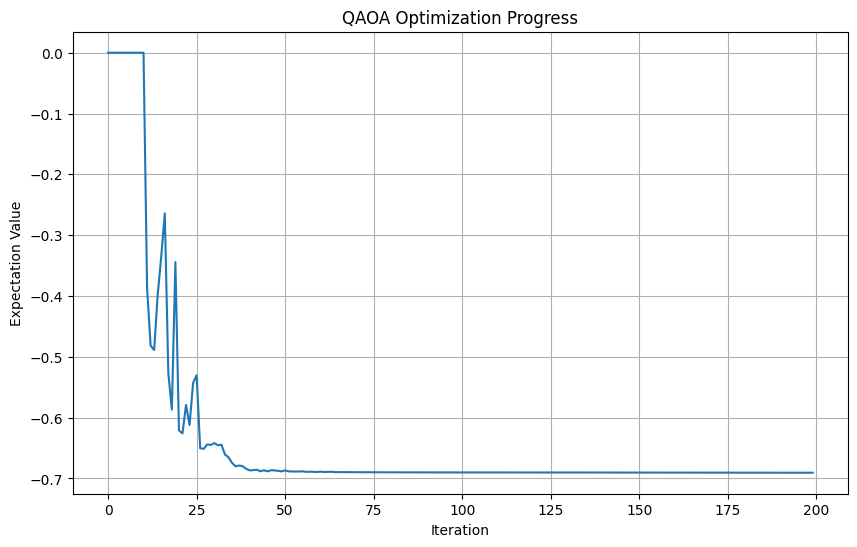

In [7]:
import matplotlib.pyplot as plt


layers = 3
init = np.random.uniform(0, 0, 2*layers)

initial= cudaq.sample(qaoa_kernel, init, n, layers,  # Sample results from initial state with all 0 parameters
                     h_list, pair_inds, J_list, shots_count=10000)

print(initial)


cost_history = []

def qaoa_cost(theta):
    res = cudaq.observe(qaoa_kernel, H, theta, n, layers,
                        h_list, pair_inds, J_list)
    cost = res.expectation()
    cost_history.append(cost)
    
    return cost

opt_result = minimize(qaoa_cost, init, method='COBYLA',
                      options={'maxiter': 200, 'disp': True})


print(opt_result)

shots = cudaq.sample(qaoa_kernel, opt_result.x, n, layers,
                     h_list, pair_inds, J_list, shots_count=10000)

print(shots)
print('Most-probable bit-string :', np.array(shots.most_probable()).astype(str))

plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel("Expectation Value")
plt.title('QAOA Optimization Progress')
plt.grid(True)
plt.show()

The QAOA result may not produce the optimal portfolio most frequently due to the *approximate* nature of QAOA.  However, the resulting QAOA state should sample the optimal portfolio with much higher probability than randomly sampling all bitstrings. Run the script below on the sample results and confirm that the optimal portfolio is at least in the top 5 results sampled from the QAOA procedure.

In [8]:
from helper import top_k_bitstrings

# Enter a CUDA-Q Sampleresult, Q, and the number of top bistrings to list
top5 = top_k_bitstrings(shots, Q, k=5) 

0001   prob = 0.260   QUBO = -0.150000
0000   prob = 0.236   QUBO = 0.000000
0100   prob = 0.158   QUBO = -0.300000
0101   prob = 0.134   QUBO = -0.290000
0011   prob = 0.060   QUBO = -0.050000


This variability can make it challenging to assess a particular optimization method. For example, what if you run QAOA and produce a state that only samples the second best portfolio?   If there are quintillions of portfolios, that is not too bad!  Result quality for simulated quantum algorithms is often quantified with a so called approximation ratio.  This ratio can be defined a few ways, but the idea is to see how close the result is to the optimal portfolio.

A pragmatic way to do this is take the best result from the sample and compare it to the optimal value. For a small problem like you completed, that will probably be trivially 1 as you sample the optimal state many times. A better estimate to assess the algorithm performance is the average sample result divided by the optimal value.  This approach can also help prove that the QAOA procedure really did help produce a state that samples better portfolios and that you did not just get lucky sampling the ground state. 

To better visualize the performance of your QAOA function, use the `plot_samples_histogram` function to plot a sample from the QAOA kernel with your initial parameters (a uniform superposition as all variational parameters are 0) and the final state you produced.  We've labeled "Good Portfolios" as those results that correspond to a negative $H_C$ value. Did the algorithm work?  

Note, `plot_samples_histogram` takes the initial and final CUDA-Q sample results as inputs, as well as the list of all solutions output by the `evaluate_all_bitstrings` function you wrote previously.

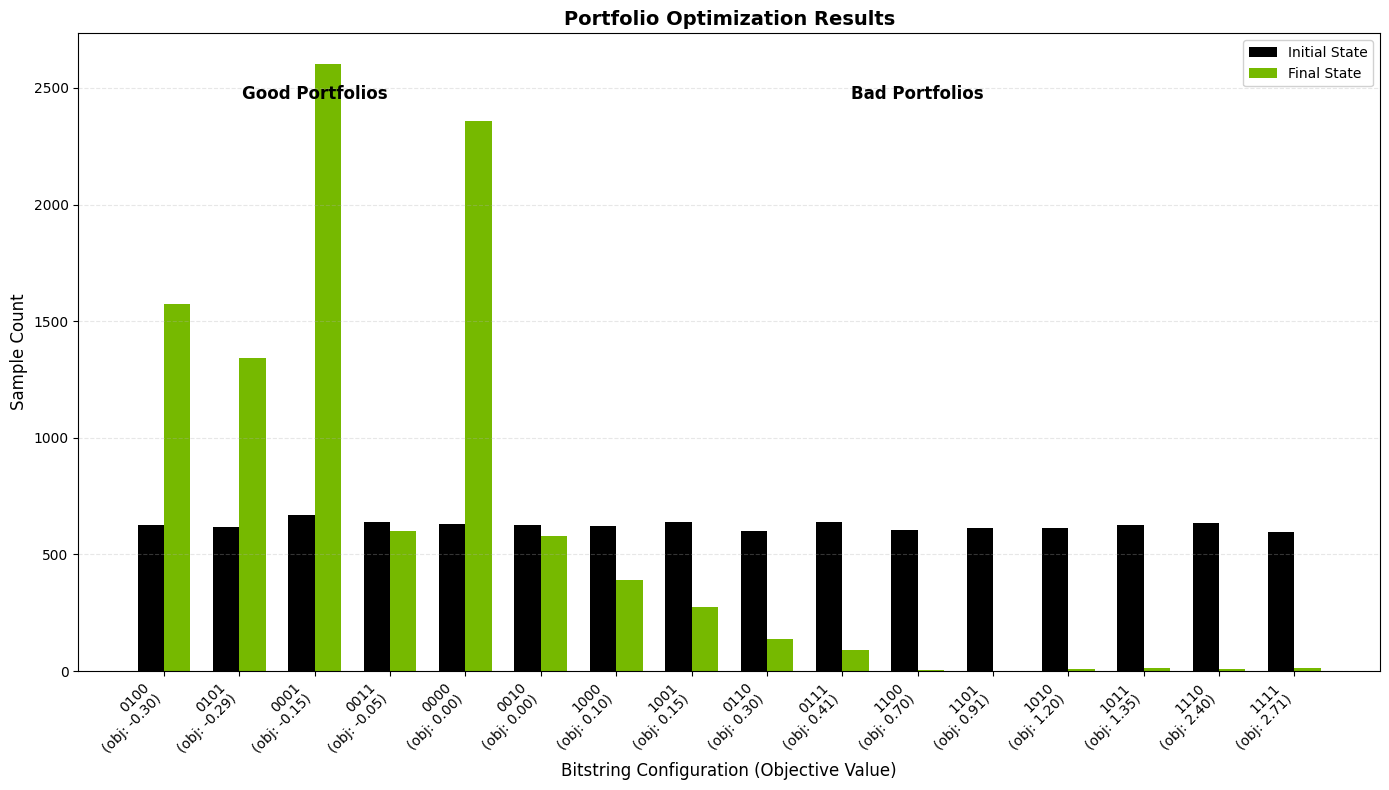

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from helper import plot_samples_histogram

fig, ax = plot_samples_histogram(initial, shots, all_solutions, 
                                "Portfolio Optimization Results")
plt.show()

Assume you are a portfolio manager and you need to be confident that you are suggesting a portfolio that has more reward than risk (a negative cost function value in this case).  From the histogram, estimate the probability of choosing a good portfolio from the initial solution and your QAOA solution?  

Though the example in this lab is small, it can be easily scaled up.  In fact, the same approach used in "[Divide and Conquer MaxCut QAOA](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut)" can potentially be used here to divide the problem into sub QAOA problems which can be solved in parallel and then knit together to obtain the final results. However, this depends on the sparsity of the QUBO and can only be used if certain stocks have negligible covariance.

Another possible aporoach is to use AI.  Rather than performing the QAOA optimization to produce the circuit corresponding to the ground state, techniques like [QAOA-GPT](https://arxiv.org/abs/2504.16350) can use a generative model to sample QAOA circuits.  Such an approach has promise, but is highly dependent on quality training data such that generated circuits are good approximations for the ground state.

## Adiabatic Approach

An alternative to gate-based quantum computation is annealing. Annealing can be used to solve optimization problems encoded into a QUBO Hamiltonian like you have already done. The difference is that annealing takes advantage of a special Hamiltonian of the form 

$$ H = (1-t)H_{initial} + (t)H_{objective} $$

The adiabatic theorem states that such a Hamiltonian will remain in its ground state if the system evolves slowly enough. Consider why this is advantageous here.  At $t=0$, the system Hamiltonian is exactly $H_{initial}$. In practice, $H_{initial}$ is selected to have a very easy to prepare ground state.  Avoiding costly state preparation routines enables such an approach to more easily run on quantum hardware. 

<img src="images/adiabatic.png" alt="Diagram of Adiabatic Approach" style="width: 900px;"/>



Though easier said than done, if an appropriate annealing schedule is chosen, $H$ will evolve from $H_{initial}$ to a mixture of $H_{initial}$ and $H_{objective}$ to a final state corresponding to the ground state of $H_{objective}$. This state is the exact same as what QAOA is trying to approximate.

CUDA-Q can simulate such an evolution using its dynamics solvers which solve the differential equations that govern such an evolution. The code below will use annealing to find an optimal portfolio. The $H_{initial}$ is selected to be Pauli-$X$ operations on all qubits which corresponds to the easily prepared $\ket{+}^{\otimes n}$ state. The problem Hamiltonian, $H_{objective}$, is just the cost Hamiltonian that you used for QAOA.

Using the `cudaq.evolve` API, the simulation is run and produces the state below.  This state can be input into a kernel and sampled similarly to the final state from the QAOA result. Note, the `dynamics` backend needs to be set in order to run `evolve`, but the backend must switch back to `nvidia` to build and sample the resulting state.

**Exercise 4:**

Confirm the approach works. Notice how the variable $T$ controls how fact the evolution occurs. Try rerunning with $T=10$.  What happens to the quality of the result?  

💻 Just a heads-up: The remainder of this notebook is designed to be run on an environment with a GPU. If you don't have access to a GPU, feel free to read through the cells and explore the content without executing them. Enjoy learning! ⭐

      (0.144351,0.0461535)
    (0.00924949,0.0378468)
     (0.0733856,-0.622876)
   (0.00536638,0.00118053)
     (0.0609038,0.0768799)
(-0.000918349,0.000335419)
    (0.0143262,0.00977498)
(-2.47359e-05,3.71109e-05)
       (0.31733,-0.115873)
      (0.0173565,0.030975)
     (0.0958287,-0.654999)
   (0.00416035,0.00101018)
      (0.119845,0.0628116)
(-0.000480642,0.000630832)
    (0.0117838,0.00799256)
(-1.71022e-05,2.57907e-05)



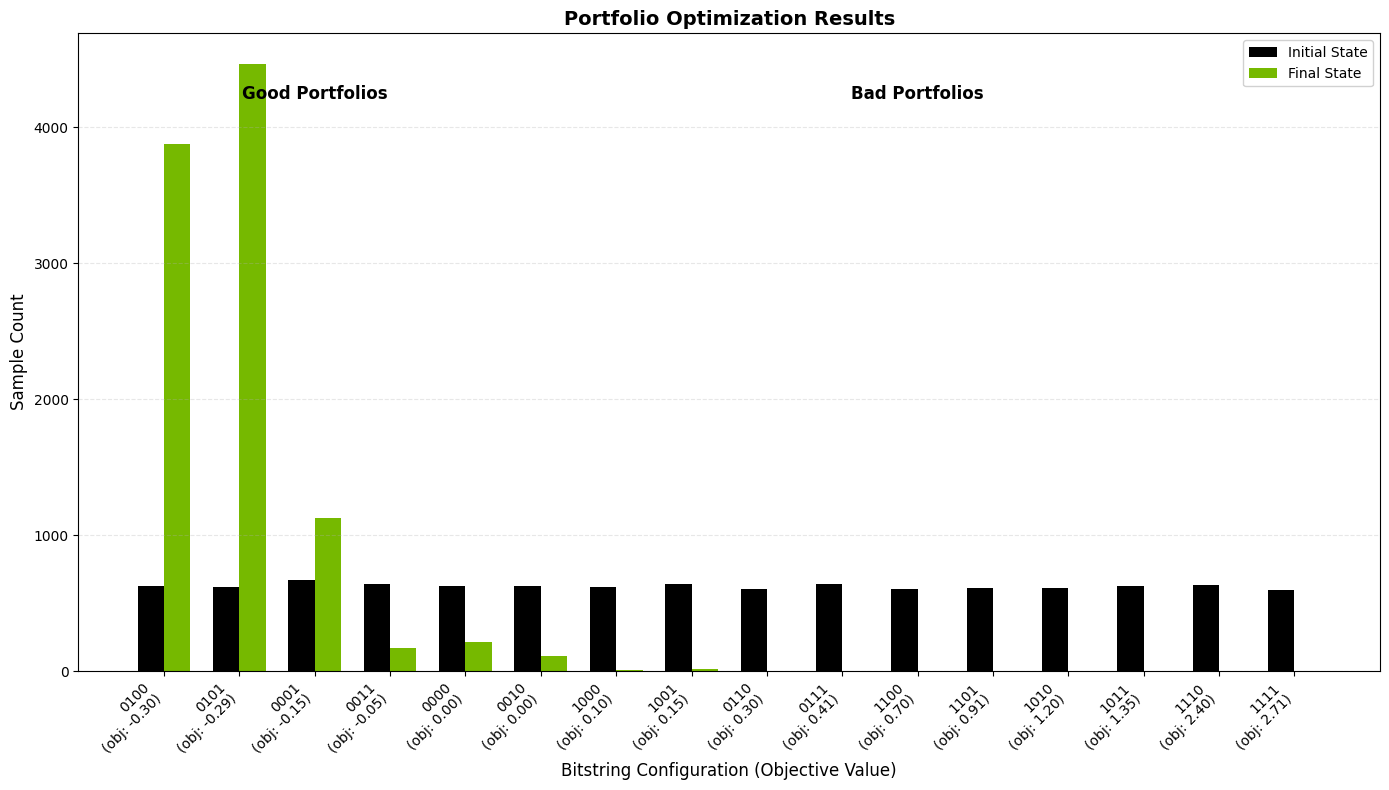

In [10]:
from cudaq import spin, boson, ScalarOperator, Schedule, ScipyZvodeIntegrator

cudaq.set_target('dynamics')

dimensions = {0: 2, 1:2, 2:2, 3:2}

Hinitial = cudaq.SpinOperator()
for i in range(n):
    Hinitial += spin.x(i)

Htotal = (1 - ScalarOperator(lambda t: t/T)) * Hinitial -  ScalarOperator(lambda t: t/T) * H

T=100

n = 4                             # example size
amp = (1/np.sqrt(2**n)) * np.ones(2**n, dtype=np.complex128)
psi0 = cudaq.State.from_data(amp)

steps = np.linspace(0, T, 100000)

schedule = Schedule(steps, ["t"])


evolution_result = cudaq.evolve(
    Htotal,
    dimensions,
    schedule,
    psi0,
    observables=[H],
    collapse_operators=[],
    integrator=ScipyZvodeIntegrator())


print(evolution_result.final_state())
state = evolution_result.final_state()
c = np.array(state).tolist()

cudaq.set_target('nvidia')

@cudaq.kernel
def final_state(amplitudes: list[complex]):
    q = cudaq.qvector(amplitudes)


dynamics_final = cudaq.sample(final_state, c, shots_count =10000)

fig, ax = plot_samples_histogram(initial, dynamics_final, all_solutions, 
                                "Portfolio Optimization Results")

## Adding Constraints


In practice, it is often helpful to constrain a portfolio optimization problem. Maybe a portfolio manager wants to only select a portfolio consisting of $k$ stocks rather than all possible combinations considered thus far.  This means that the there is now some range of feasible solutions where exactly $k$ stocks are selected. 


The constraint can be easily added to the QUBO by adding a quadratic constraint term of the form $ (\sum_i x_i - k)^2$ to produce 

$$ x^TQx = \sum_i Q_{ii} x_i + \sum_{i<j} Q_{ij} x_i  x_j  + ( \sum_i x_i - k )^2$$

Expanding the constraint term results in:

$$
\begin{aligned}
( \sum_i x_i - k)^2 &= ( \sum_i x_i )^2 -2k \sum_i x_i + k^2 \\
& = ( \sum_i x_i^2 + \sum_{i\ne j}x_i x_j) -2k \sum_i x_i + k^2
\end{aligned}
$$

Because $x_i$ is binary, we can replace $\sum_i x_i^2$ with $\sum_i x_i$. So our expressions becomes: 

$$ 
\begin{aligned} (\sum_i x_i - k)^2 & = \\
& = (\sum_i x_i + \sum_{i \ne j} x_i x_j)  -2k\sum_i x_i + k^2\\
& = (1-2k)\sum_i x_i + \sum_{i \ne j} x_i x_j + k^2 
\end{aligned}$$


Generally, the constraint has a factor  $\lambda$ which is a tuneable parameter for the strength of the constraint. After working out the example, there is a $\lambda(1-2k)$ factor added to the diagonal terms, a $2\lambda$ term added to each off diagonal (the 2 comes from the upper diagonal QUBO form we are using), and a constant term of $\lambda k^2$, which is often omitted since it has no impact on the result. 

**Exercise 5:**

Write a new `portfolio_to_qubo` function below which now adds constraints to restrict the portfolio solutions  to $k$ stocks. Using all of the functions created earlier, rerun an adiabatic simulation of this constrained result.  Does the histogram produced below indicate that the constraint worked?

[[-29.9   20.9   21.1   20.2 ]
 [  0.   -30.3   20.6   20.16]
 [  0.     0.   -30.    20.1 ]
 [  0.     0.     0.   -30.15]]

Best solution:
x* = [0 1 0 1]
Objective value = -40.290000

Worst solution:
x* = [1 1 1 1]
Objective value = 2.710000
 (-2.04947e-06,8.79749e-06)
 (-0.000260591,3.06127e-05)
 (-0.000639936,-0.00097222)
(-4.18599e-05,-1.68845e-05)
(-0.000415243,-0.000256512)
(-3.53434e-05,-2.78971e-05)
  (0.000930297,0.000459153)
  (-0.00755118,-0.00166496)
 (-0.00065576,-0.000671068)
    (0.00148135,0.00594325)
        (0.973188,0.201806)
 (-0.000717872,9.41707e-05)
      (0.00503551,0.109147)
  (0.000403979,0.000832504)
 (0.000433234,-0.000311732)
  (3.33265e-05,3.41254e-06)



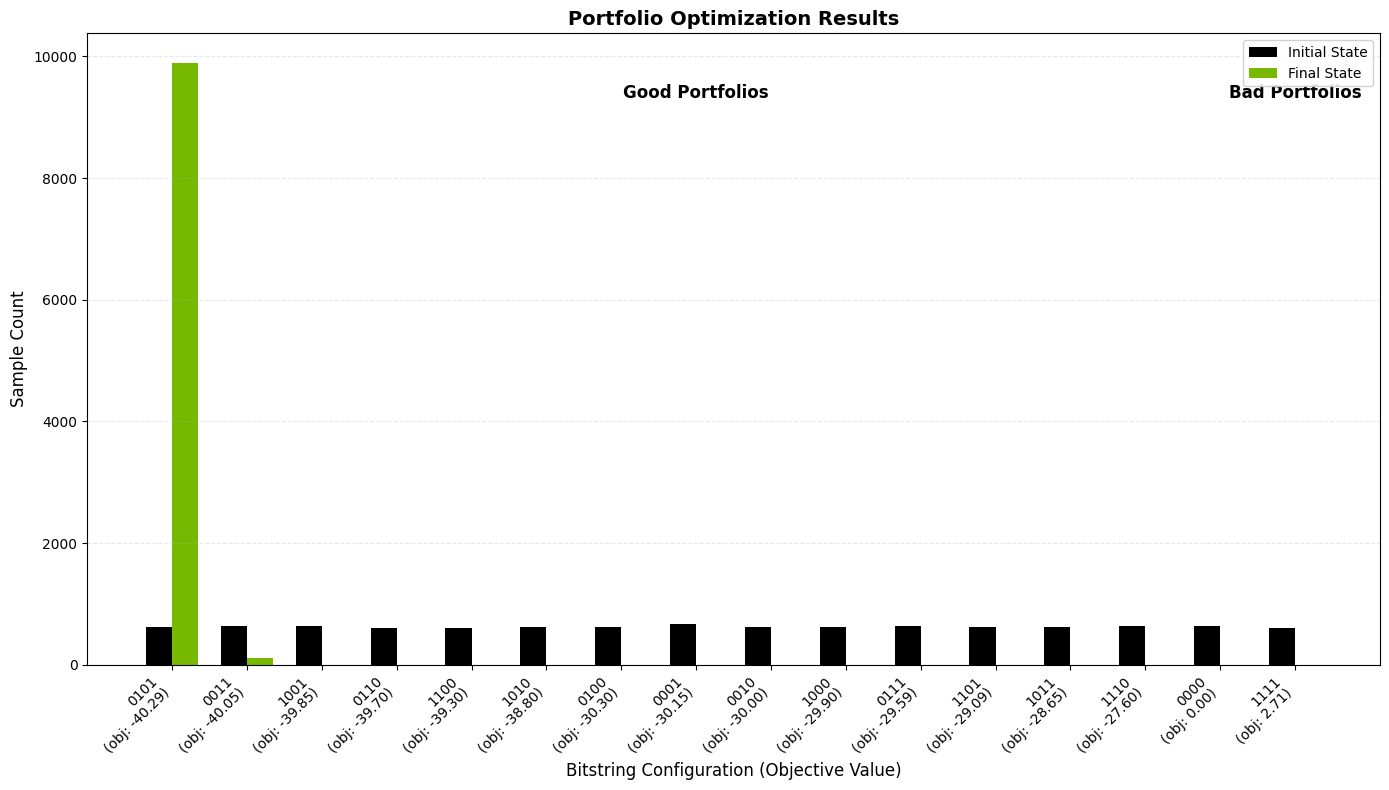

In [ ]:
def portfolio_to_qubo_constrained(mu, Sigma, alpha=1., beta=1., lam =10, k = 2):
    """
    Convert financial data into a QUBO Matrix
    
    Args:
        mu (np.array): length n vector of portfolio returns
        Sigma (np.array): nxn matrix of portfolio pair covariances
        alpha (float): tunable parameter for valuing return
        beta (float): tunable parameter for valuing risk
        lam (float): tuanble penalty for constraint violation
        k (int): constrain to favor portfolios of k stocks
    
    Returns:
        Q (np.array): upper triangular QUBO Matrix
    """
    
    n = len(mu)
    Q = np.zeros((n, n))
    # EDIT CODE BELOW THIS LINE
    # Populate matrix Q with values 

    # EDIT CODE ABOVE THIS LINE
        
    return Q

Q_con = portfolio_to_qubo_constrained(mu, Sigma, alpha, beta, lam =10, k =2)
print(Q_con)

best_x, best_val, worst_x, worst_val, all_solutions = evaluate_all_bitstrings(Q_con)


h_list_con, pair_inds_con, J_list_con =    qubo_to_ising(Q_con) 

H_con = ising_to_spinop(h_list_con, pair_inds_con, J_list_con, n)



from cudaq import spin, boson, ScalarOperator, Schedule, ScipyZvodeIntegrator

cudaq.set_target('dynamics')

dimensions = {0: 2, 1:2, 2:2, 3:2}

Hinitial = cudaq.SpinOperator()
for i in range(n):
    Hinitial += spin.x(i)

Htotal = (1 - ScalarOperator(lambda t: t/T)) * Hinitial -  ScalarOperator(lambda t: t/T) * H_con

T=100

n = 4                             # example size
amp = (1/np.sqrt(2**n)) * np.ones(2**n, dtype=np.complex128)
psi0 = cudaq.State.from_data(amp)

steps = np.linspace(0, T, 10000)
schedule = Schedule(steps, ["t"])


evolution_result = cudaq.evolve(
    Htotal,
    dimensions,
    schedule,
    psi0,
    observables=[H_con],
    collapse_operators=[],
    integrator=ScipyZvodeIntegrator())


print(evolution_result.final_state())
state = evolution_result.final_state()
c = np.array(state).tolist()

cudaq.set_target('nvidia')

@cudaq.kernel
def final_state(amplitudes: list[complex]):
    q = cudaq.qvector(amplitudes)


dynamics_final_con = cudaq.sample(final_state, c, shots_count =10000)

fig, ax = plot_samples_histogram(initial, dynamics_final_con, all_solutions, 
                                "Portfolio Optimization Results")

## Improving Adiabatic Convergence with Q-CHOP

Adding a constraint means that you no longer care about the entire universe of $2^n$ portfolios, but only a subset of feasible solutions.  Though the standard adiabatic approach always ends with a feasible ground state solution of the total Hamiltonian, it is not guaranteed to remain within the feasible space of solutions during the evolution. If somehow, the evolution process could remain within the feasible solution space, convergence could be much faster and potentially reach higher quality solutions. 

The [Q-CHOP Algorithm](https://arxiv.org/abs/2403.05653) developed by Infleqtion and JPMorgan Chase does just that and provides a clever way to modify the evolution process to remain within the feasible solution space. Q-CHOP takes advantage of the fact that it is sometimes easy to prepare the worst feasible solution.  The Q-CHOP evolution starts with the Hamiltonian whose ground state is equal to the worst feasible state and slowly rotates it (within the subspace of feasible solutions) to the problem Hamiltonian, resulting in a ground state of the problem Hamiltonian. The advantage of this is a procedure that can both converge faster and produce higher quality results by ensuring the evolution remains within the feasible space of solutions. 

<img src="images/qchop_diagram.png" alt="Diagram of the QChop Algorithm" style="width: 900px;"/>

An astute reader might rightfully question the fact that it is easier to prepare the worst feasible state for portfolio optimization problems.  This observation is correct: finding the worth feasible state is just as hard as finding the best possible state! The Q-CHOP developers circumvent this with a clever two-stage approach.  First, they run Q-CHOP from an arbitrary feasible state. This is trivial to prepare as you can select any state that satisfies the constraint. 

Then, they use a modified objective function of the form $(H_{objective} - E_{initial})^2$.  This will drive the evolution towards *either* the best or worst feasible state. If the result is the best state, the problem is solved.  If it is the worst, a second Q-CHOP run can be initialized from it. Remarkably, even if Q-CHOP requires both stages, it can still converge faster and to higher quality solutions than the standard adiabatic approach.

The Q-CHOP code is proprietary, so it cannot be interacted with directly. However, the widget below will allow you to compare a Q-CHOP run against a standard adiabatic approach.  The left panel is a case where Q-CHOP requires only a single run since it lands on the best feasible state while the second panel is the two-stage situation in which the worst feasible state is found in the initial run.

<iframe src="https://nvidia.github.io/cuda-q-academic/quantum-applications-to-finance/images/Q_CHOP_Animated.html" width="800" height="600"></iframe>


Infleqtion used CUDA-Q dynamics to perform portfolio optimization on real financial data which is detailed in [Spotlight: Infleqtion Optimizes Portfolios Using Q-CHOP and NVIDIA CUDA-Q Dynamics](https://developer.nvidia.com/blog/spotlight-infleqtion-optimizes-portfolios-using-q-chop-and-nvidia-cuda-q-dynamics/). For instances of selecting portfolios of size 7 or 8 from 15 possible stocks, Q-CHOP on average could produce a solution within 99.5% of the optimal solution with just 70 samples. This is three orders of magnitude fewer samples than is required to search the 12,870 potential portfolios by random sampling and provides great promise for future larger scale runs on physical QPUs.

## Scaling Up Sampling 

It is worth a brief mention of the fact that the QAOA and adiabatic approaches both require sampling a final state after the algorithm completes. When sampling on a phsyical QPU, this means a circuit must prepare the target state and measure it for every single shot. For simulation this is easy, especially for small problem sizes, but this can be very time consuming and limit the sampling that can be done on a QPU.  For larger portfolio optimization problems, there is a tradeoff between the number of samples taken and the best solution sampled.


**Exercise 6 :**

Using the code below, generate random $\mu$ and $\sigma$ for $n=15$ stocks. Use your previous functions to run a QAOA. Run four different samples of the final state with 50, 100, 500, and 1000 shots and check how many times the optimal portfolio is sampled.  For this rather modest problem size, is there risk it is missed?

In [12]:
def generate_portfolio_params(n, seed=42):
    """
    Generate a random covariance matrix and mean vector for portfolio optimization
    
    Args:
    n: size of the matrix/vector
    seed: random seed for reproducibility

    Returns:
    mu (np.array): vector of lenght n of stock returns
    Sigma (np.array): n x n matrix of stock covariances
    """
    np.random.seed(seed)
    
    # Generate random expected returns (mu) between 0.1 and 1.0
    mu = np.random.uniform(0.1, 1.0, n)
    
    # Generate a random positive semi-definite covariance matrix
    # Method: Create a random matrix A, then Sigma = A * A^T
    A = np.random.randn(n, n)
    Sigma = np.dot(A, A.T)
    
    # Scale the covariance matrix to reasonable values
    Sigma = Sigma / np.max(Sigma) * 0.9  # Scale max to 0.9
    
    # Ensure diagonal elements are positive (variances)
    np.fill_diagonal(Sigma, np.abs(np.diag(Sigma)) + 0.05)
    
    return mu, Sigma


big_mu, big_sigma = generate_portfolio_params(n)

Q_big = portfolio_to_qubo(big_mu, big_sigma)

best_x_big, best_val_big, worst_x_big, worst_val_big, all_solutions_big = evaluate_all_bitstrings(Q_big)

h_list_big, pair_inds_big, J_list_big =    qubo_to_ising(Q_big) 

H_big = ising_to_spinop(h_list_big, pair_inds_big, J_list_big, n)


Best solution:
x* = [1 1 1 0]
Objective value = -1.587175

Worst solution:
x* = [1 1 1 1]
Objective value = -1.442629


In [13]:
layers = 3

init = np.random.uniform(0, 0, 2*layers)

initial_big = cudaq.sample(qaoa_kernel, init, n, layers,
                     h_list_big, pair_inds_big, J_list_big, shots_count=1000)

def qaoa_cost(theta):
    res = cudaq.observe(qaoa_kernel, H_big, theta, n, layers,
                        h_list_big, pair_inds_big, J_list_big)
    return res.expectation()

opt_result = minimize(qaoa_cost, init, method='COBYLA',
                      options={'maxiter': 500, 'disp': True})

print(opt_result)

shots_big = cudaq.sample(qaoa_kernel, opt_result.x, n, layers,
                     h_list_big, pair_inds_big, J_list_big, shots_count=1000)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.9192384128095067
       x: [-9.114e-01 -1.534e+00 -2.182e+00  7.752e-01  5.334e-01
            1.927e-01]
    nfev: 500
   maxcv: 0.0

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  500   F =-9.192384E-01    MAXCV = 0.000000E+00
   X =-9.114464E-01  -1.533752E+00  -2.181547E+00   7.752210E-01   5.333648E-01
       1.927385E-01


In [ ]:
#TODO START
# Produce the appropriate samples sizes and count how many have the optimal portfolio

shots_big_50 = cudaq.sample(#FIX_ME#)

shots_big_100 = cudaq.sample(#FIX_ME#)

shots_big_500 = cudaq.sample(#FIX_ME#)

shots_big_1000 = cuda)

best = "".join(best_x_big.astype(str))

print("\n Number of times best portfolio is sampled in 50 shots:", shots_big_50.count(best))
print("\n Number of times best portfolio is sampled in 100 shots:" , shots_big_100.count(best))
print("\n Number of times best portfolio is sampled in 500 shots:", shots_big_500.count(best))
print("\n Number of times best portfolio is sampled in 1000 shots:", shots_big_1000.count(best))
# TODO END


 Number of times best portfolio is sampled in 50 shots: 16

 Number of times best portfolio is sampled in 100 shots: 34

 Number of times best portfolio is sampled in 500 shots: 214

 Number of times best portfolio is sampled in 1000 shots: 438


Notice when a small number of samples is run, it is quite possible for the optimal solution to be missed. Our example of $n=15$ is rather modest, and this problem likey gets worse with larger problem sizes.  So, every shot matters to improve the quality of the portfolios generated from such an application.  One way to handle situations like this in the future will be to parallelize sampling across multiple QPUs. 

CUDA-Q is designed with the capabilities for running jobs in such a multi-QPU data center.  Using the `mqpu` backend, you can sample the kernel you produced from the 15 qubit QAOA run above across multiple simulated QPUs.  If you have access to multiple GPUs, try running the code below.  

This feature can help CUDA-Q users run simulations faster (if the original task is onerous enough) and lays the groundwork for parallelizing tasks like sampling to improve algorithm results at scale.

In [15]:
import time

cudaq.set_target('nvidia', option='mqpu')

s = time.time()
result = cudaq.sample(qaoa_kernel, opt_result.x, n, layers, h_list_big, pair_inds_big, J_list_big, shots_count=8000000)
e = time.time()
print("Time to run in serial:",e-s)

start_time = time.time()
result_1 = cudaq.sample_async(qaoa_kernel, opt_result.x, n, layers, h_list_big, pair_inds_big, J_list_big, shots_count=2000000, qpu_id=0)
result_2 = cudaq.sample_async(qaoa_kernel, opt_result.x, n, layers, h_list_big, pair_inds_big, J_list_big, shots_count=2000000, qpu_id=1)
result_3 = cudaq.sample_async(qaoa_kernel, opt_result.x, n, layers, h_list_big, pair_inds_big, J_list_big, shots_count=2000000, qpu_id=2)
result_4 = cudaq.sample_async(qaoa_kernel, opt_result.x, n, layers, h_list_big, pair_inds_big, J_list_big, shots_count=2000000, qpu_id=3)
result_1.get()
result_2.get()
result_3.get()
result_4.get()
end_time = time.time()
print("Time to run in parallel:", end_time - start_time)

Time to run in serial: 3.0732595920562744
Time to run in parallel: 2.091329574584961


## Summary

You have now sucessfully learned how to use CUDA-Q to solve portfolio optimization problems and more generally, any problem that can be formulated as a QUBO.  You have learned two different approaches to solving such problem using methods like gate-based QAOA or adiabatic apprioaches simulatd with CUDA-Q `dynamics` and explored stat-of-the-art approaches like Q-CHOP to more efficently solve QUBO problems.  

If you want to learn more about scaling up quantum solution of optimization problems, check out the "[Divide and Conquer MaxCut QAOA](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut)". Additionally, other applications can be found in the [CUDA-Q docs](https://nvidia.github.io/cuda-quantum/latest/using/applications.html).